In [9]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 
# Import necessary libraries
import matplotlib.pyplot as plt # For general plotting
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.stats import multivariate_normal as mvn
from skimage.io import imread
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
from math import ceil, floor 


import torch
import torch.nn as nn
import torch.nn.functional as F


# Adjust display settings for readability
np.set_printoptions(suppress=True)

# Set a specific seed for reproducible results
np.random.seed(7)

# Customize font sizes for better visualization
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

In [10]:
def plot_binary_classification_results(ax, predictions, labels):
    # Get indices of the four decision scenarios:
    # True Negatives
    tn = np.argwhere((predictions == -1) & (y_test == -1))
    # False Positives
    fp = np.argwhere((predictions == 1) & (y_test == -1))
    # False Negative Probability
    fn = np.argwhere((predictions == -1) & (y_test == 1))
    # True Positive Probability
    tp = np.argwhere((predictions == 1) & (y_test == 1))
    ax.plot(X_test[tn, 0], X_test[tn, 1], 'og', label="Correct Class -1");
    ax.plot(X_test[fp, 0], X_test[fp, 1], 'or', label="Incorrect Class -1");
    ax.plot(X_test[fn, 0], X_test[fn, 1], '+r', label="Incorrect Class 1");
    ax.plot(X_test[tp, 0], X_test[tp, 1], '+g', label="Correct Class 1");

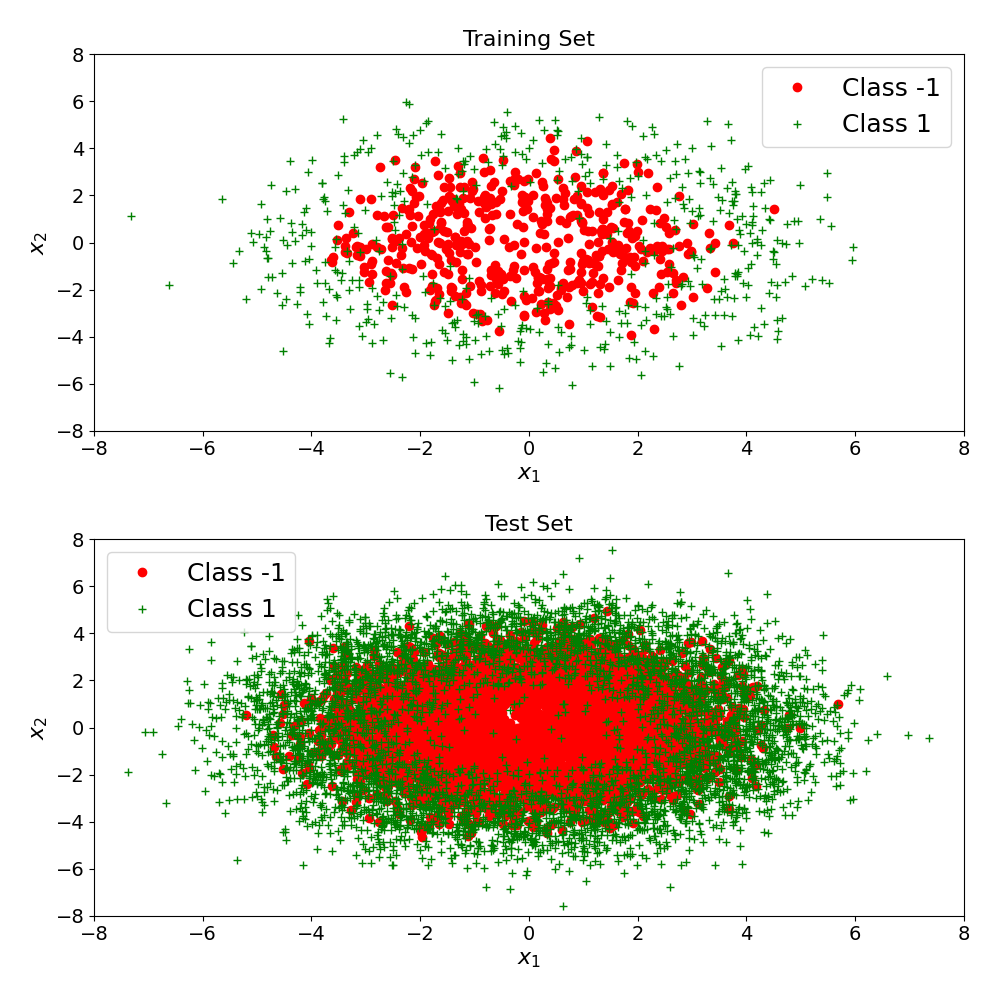

In [13]:
def generate_multiring_dataset(N, n, pdf_params):
    # Output samples and labels
    X = np.zeros([N, n])
    # Note that the labels are either -1 or +1, binary classification
    labels = np.ones(N)
    
    # Decide randomly which samples will come from each class
    indices = np.random.rand(N) < pdf_params['prior']
    # Reassign random samples to the negative class values (to -1)
    labels[indices] = -1
    num_neg = sum(indices)

    # Create mixture distribution
    theta = np.random.uniform(low=-np.pi, high=np.pi, size=N)
    uniform_component = np.array([np.cos(theta), np.sin(theta)]).T

    # Positive class samples
    X[~indices] = pdf_params['r+'] * uniform_component[~indices] + mvn.rvs(pdf_params['mu'], pdf_params['Sigma'],
                                                                           N-num_neg)
    # Negative class samples
    X[indices] = pdf_params['r-'] * uniform_component[indices] + mvn.rvs(pdf_params['mu'], pdf_params['Sigma'],
                                                                         num_neg)
    return X, labels

n = 2
mix_pdf = {
    'r+':4,
    'r-':2,
    'prior':0.5,
    'mu':np.zeros(n),
    'Sigma':np.identity(n) }
N_train = 1000
N_test = 10000

X_train, y_train = generate_multiring_dataset(N_train, n, mix_pdf)
X_test, y_test = generate_multiring_dataset(N_test, n, mix_pdf)

fig, ax = plt.subplots(2, 1, figsize=(10,10))

ax[0].set_title("Training Set")
ax[0].plot(X_train[y_train==-1, 0], X_train[y_train==-1, 1], 'ro', label="Class -1")
ax[0].plot(X_train[y_train==1, 0], X_train[y_train==1, 1], 'g+', label="Class 1")
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")
ax[0].legend()

ax[1].set_title("Test Set")
ax[1].plot(X_test[y_test==-1, 0], X_test[y_test==-1, 1], 'ro', label="Class -1")
ax[1].plot(X_test[y_test==1, 0], X_test[y_test==1, 1], 'g+', label="Class 1")
ax[1].set_xlabel(r"$x_1$")
ax[1].set_ylabel(r"$x_2$")
ax[1].legend()

# Using test set samples to limit axes
x1_lim = (floor(np.min(X_test[:,0])), ceil(np.max(X_test[:,0])))
x2_lim = (floor(np.min(X_test[:,1])), ceil(np.max(X_test[:,1])))
# Keep axis-equal so there is new skewed perspective due to a greater range along one axis
plt.setp(ax, xlim=x1_lim, ylim=x2_lim)
plt.tight_layout()
plt.show()

Best Regularization Strength: 100.000
Best Kernel Width: 0.001
SVM CV Probability Error: 0.144


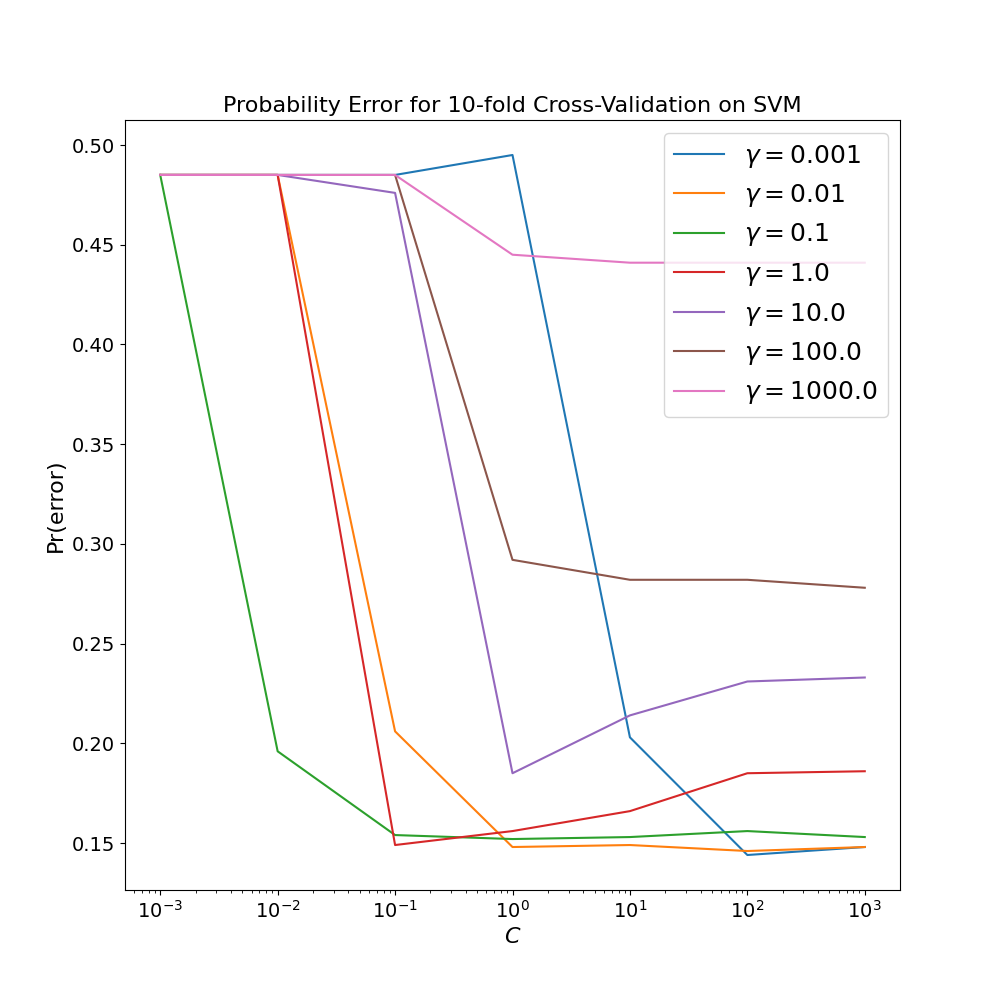

In [14]:
K = 10

C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)
param_grid = {
    'C':C_range,
    'gamma': gamma_range
}

svc = SVC(kernel='rbf')
cv = KFold(n_splits=K, shuffle=True)
classifier = GridSearchCV(estimator=svc, param_grid=param_grid, cv = cv)
classifier.fit(X_train, y_train)

C_best = classifier.best_params_['C']
gamma_best = classifier.best_params_['gamma']
print("Best Regularization Strength: %.3f" % C_best)
print("Best Kernel Width: %.3f" % gamma_best)
print("SVM CV Probability Error: %.3f" % (1-classifier.best_score_))

C_data = classifier.cv_results_['param_C'].data
gamma_data = classifier.cv_results_['param_gamma'].data
cv_prob_error = 1 - classifier.cv_results_['mean_test_score']
plt.figure(figsize=(10, 10))
# Iterate over each gamma in the parameter grid
for g in gamma_range:
    # Find what C values correspond to a specific gamma
    C = C_data[gamma_data == g]
    # Sort in ascending order
    sort_idx = C.argsort()[::-1]
    # Pick out the error associated with that gamma and C combo
    prob_error = cv_prob_error[gamma_data == g]
    plt.plot(C[sort_idx], prob_error[sort_idx], label=fr"$\gamma = {g}$")

plt.title("Probability Error for 10-fold Cross-Validation on SVM")
plt.xscale('log')
plt.xlabel(r"$C$")
plt.ylabel("Pr(error)")
plt.legend()
plt.show()


SVM Probability error on the test data set: 0.1718



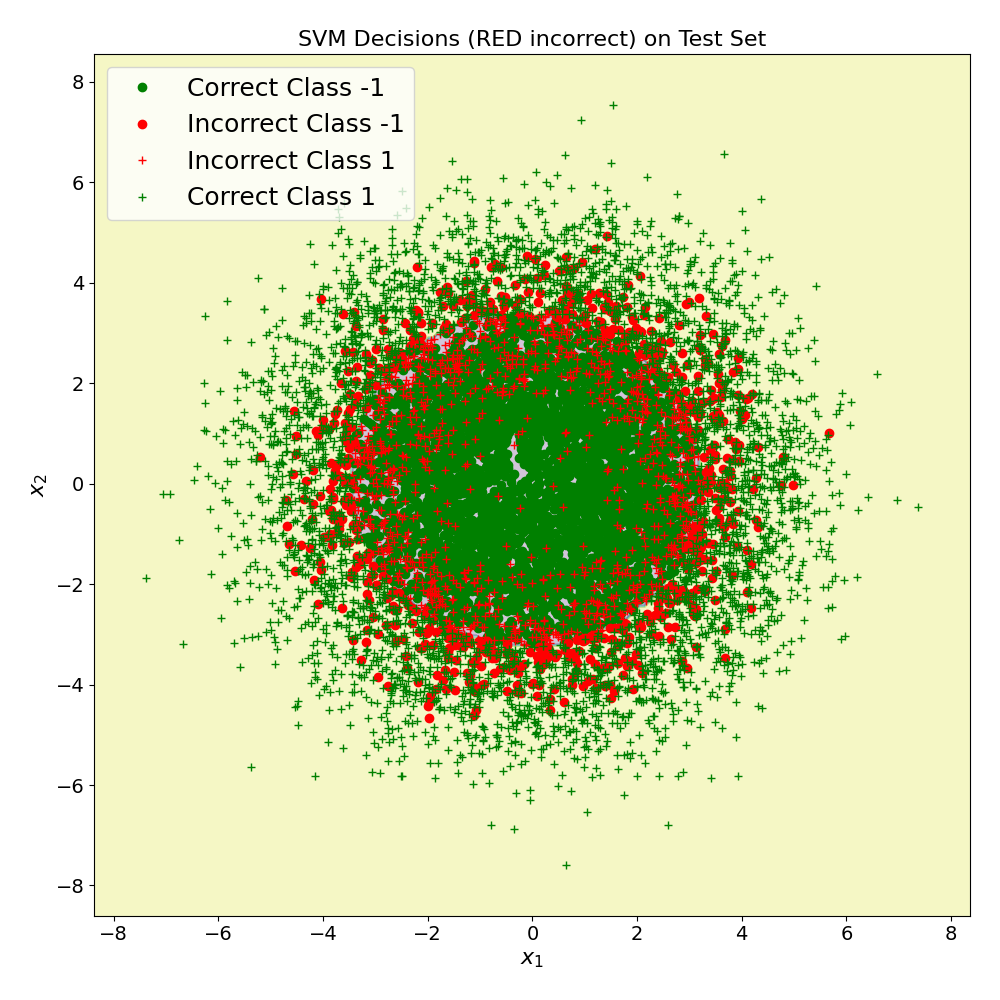

In [17]:
classifier = SVC(C=C_best, kernel='rbf', gamma=gamma_best)

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

incorrect_ind = np.argwhere(y_test != predictions)
prob_error_test = len(incorrect_ind) / N_test
print("SVM Probability error on the test data set: %.4f\n" % prob_error_test)

fig, ax = plt.subplots(figsize=(10, 10))
plot_binary_classification_results(ax, predictions, y_test)
# Define region of interest by data limits
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
x_span = np.linspace(x_min, x_max, num=200)
y_span = np.linspace(y_min, y_max, num=200)
xx, yy = np.meshgrid(x_span, y_span)

grid = np.c_[xx.ravel(), yy.ravel()]

# Z matrix are the SVM classifier predictions
Z = classifier.predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.25)

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title("SVM Decisions (RED incorrect) on Test Set")
plt.legend()
plt.tight_layout()
plt.show()

Confusion Matrix (rows: Predicted class, columns: True class):


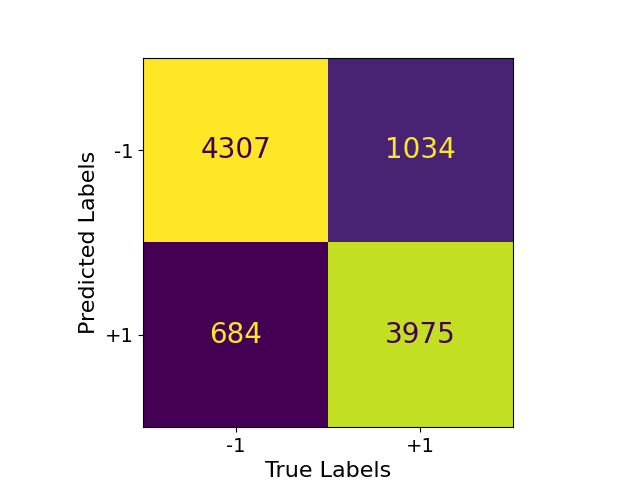

In [18]:
# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(predictions, y_test)
conf_display = ConfusionMatrixDisplay.from_predictions(predictions, y_test, display_labels=['-1', '+1'], colorbar=False)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")
plt.show()

In [19]:
class TwoLayerMLP(nn.Module):
    # Two-layer neural network class
    
    def __init__(self, in_dim, P, out_dim=1):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from n -> P
        self.input_fc = nn.Linear(in_dim, P)
        # Output layer again fully connected mapping from P -> out_dim (single output feature)
        self.output_fc = nn.Linear(P, out_dim)
        
    def forward(self, X):
        # X = [batch_size, input_dim]
        X = self.input_fc(X)
        # ReLU
        X = F.relu(X)
        # X = [batch_size, P]
        return self.output_fc(X)
        
def model_train(model, data, labels, optimizer, criterion=nn.BCEWithLogitsLoss(), num_epochs=100):
    # Set this "flag" before training
    model.train()
    # Optimize the model, e.g. a neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels.unsqueeze(1))
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model, loss


def model_predict(model, data):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_logits = model(data)
        # Take sigmoid of pre-activations (logits) for output probabilities
        predicted_probs = torch.sigmoid(predicted_logits).detach().numpy()
        # Reshape to squeeze out last unwanted dimension
        return predicted_probs.reshape(-1)


In [20]:
def k_fold_cv_perceptrons(K, P_list, data, labels):
    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True) 

    # Allocate space for CV
    error_valid_mk = np.zeros((len(P_list), K)) 

    # STEP 2: Iterate over all model options based on number of perceptrons
    # Track model index
    m = 0
    for P in P_list:
        # K-fold cross validation
        k = 0
        for train_indices, valid_indices in kf.split(data):
            # Extract the training and validation sets from the K-fold split
            # Convert numpy structures to PyTorch tensors, necessary data types
            X_train_k = torch.FloatTensor(data[train_indices])
            y_train_k = torch.FloatTensor(labels[train_indices])

            model = TwoLayerMLP(X_train_k.shape[1], P)

            # Stochastic GD with learning rate and momentum hyperparameters
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

            # Trained model
            model, _ = model_train(model, X_train_k, y_train_k, optimizer)

            X_valid_k = torch.FloatTensor(data[valid_indices])
            y_valid_k = labels[valid_indices]
            
            # Evaluate the neural network on the validation fold
            prediction_probs = model_predict(model, X_valid_k)
            # Decision boundary set to 0.5, hence rounding up sigmoid outputs
            predictions = np.round(prediction_probs)

            # Retain the probability of error estimates
            error_valid_mk[m, k] = np.sum(predictions != y_valid_k) / len(y_valid_k)
            k += 1
        m += 1
    
    # STEP 3: Compute the average prob. error (across K folds) for that model
    error_valid_m = np.mean(error_valid_mk, axis=1) 
    
    # Return the optimal choice of P* and prepare to train selected model on entire dataset
    optimal_P = P_list[np.argmin(error_valid_m)]
    
    print("Best # of Perceptrons: %d" % optimal_P)
    print("Pr(error): %.3f" % np.min(error_valid_m))

    fig = plt.figure(figsize=(10, 10))
    plt.plot(P_list, error_valid_m)
    plt.title("No. Perceptrons vs Cross-Validation Pr(error)")
    plt.xlabel(r"$P$")
    plt.ylabel("MLP CV Pr(error)")
    plt.show()

    return optimal_P

Best # of Perceptrons: 128
Pr(error): 0.160


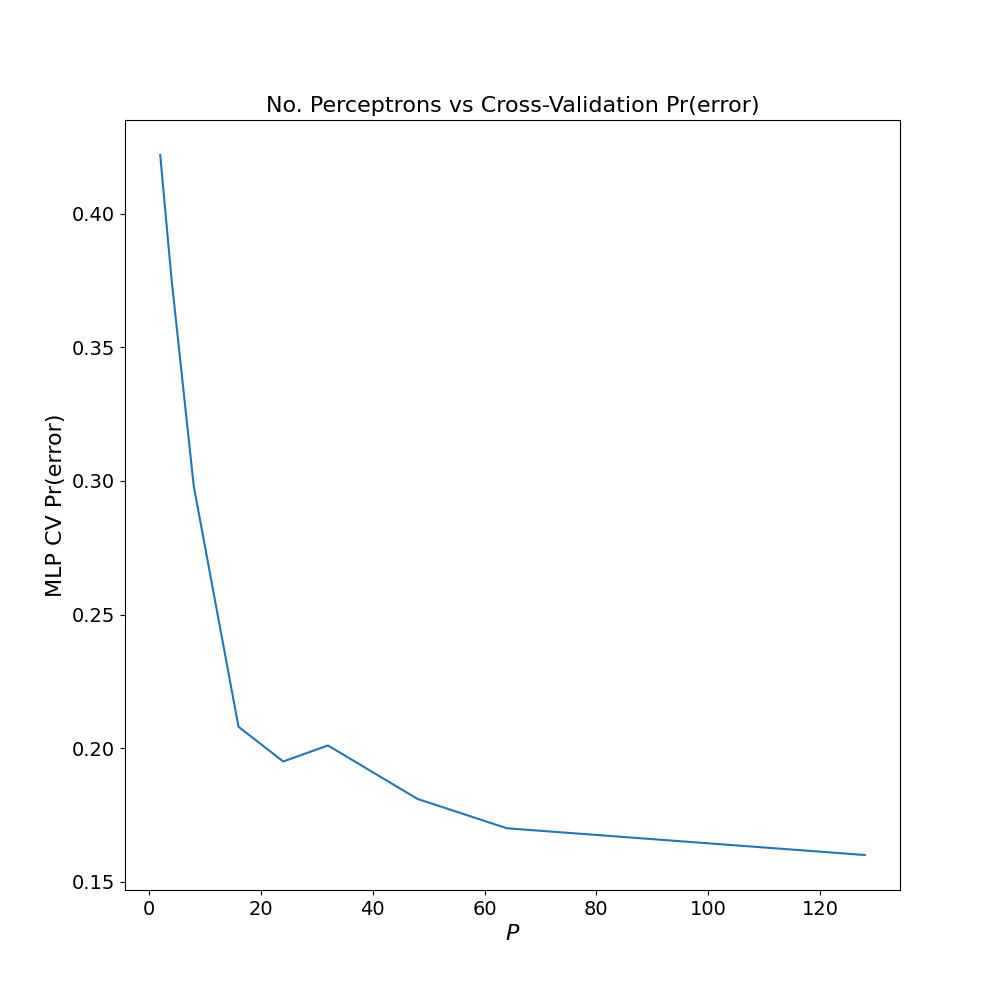

In [22]:
P_list = [2, 4, 8, 16, 24, 32, 48, 64, 128]

# Converting -1/+1 labels into a binary format, suitable for the MLP loss function
lb = LabelBinarizer()
y_train_binary = lb.fit_transform(y_train)[:, 0]

P_best = k_fold_cv_perceptrons(K, P_list, X_train, y_train_binary)

In [23]:
# Number of times to re-train same model with random re-initializations
num_restarts = 10

# Convert numpy structures to PyTorch tensors, necessary data types
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train_binary)
            
# List of trained MlPs for later testing
restart_mlps = []
restart_losses = []
# Remove chances of falling into suboptimal local minima
for r in range(num_restarts):
    model = TwoLayerMLP(X_train.shape[1], P_best)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # Trained model
    model, loss = model_train(model, X_train_tensor, y_train_tensor, optimizer)
    restart_mlps.append(model)
    restart_losses.append(loss.detach().item())

# Choose best model from multiple restarts to list
best_mlp = restart_mlps[np.argmin(restart_losses)]

MLP Pr(error) on the test data set: 0.1728



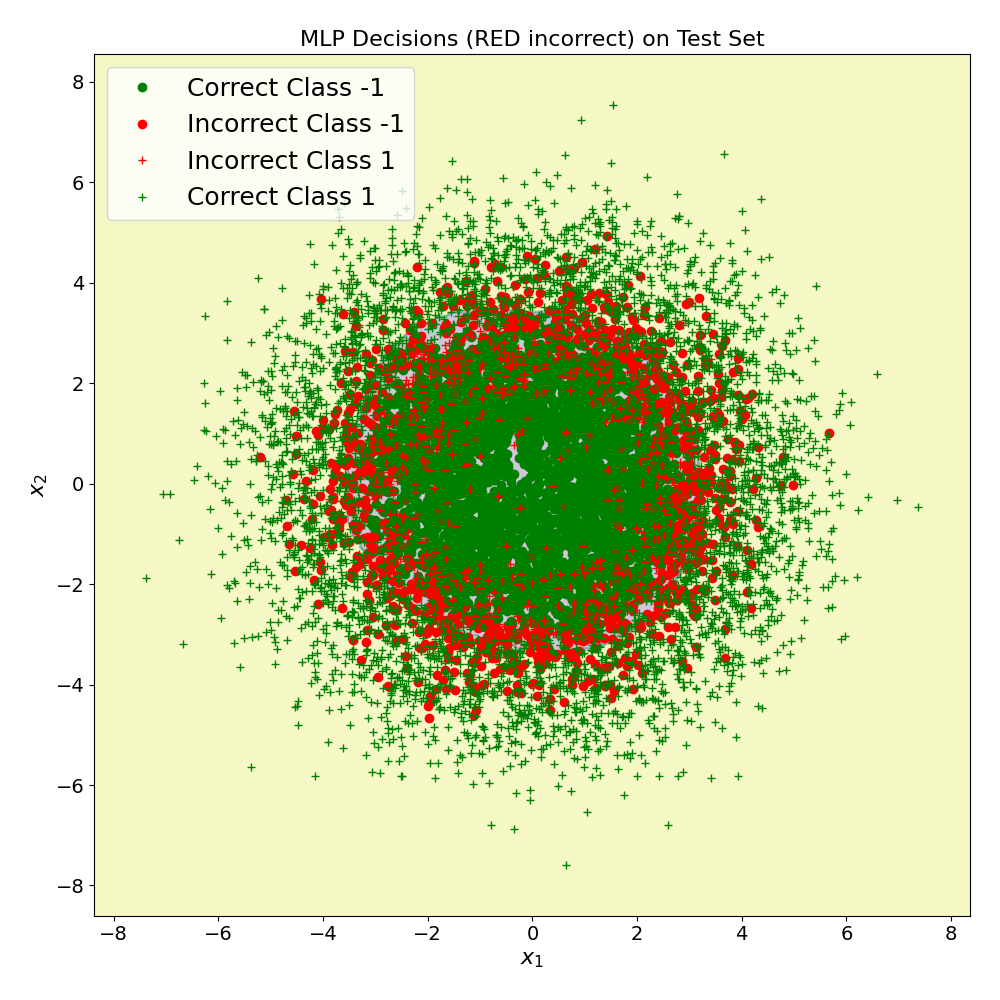

Confusion Matrix (rows: Predicted class, columns: True class):


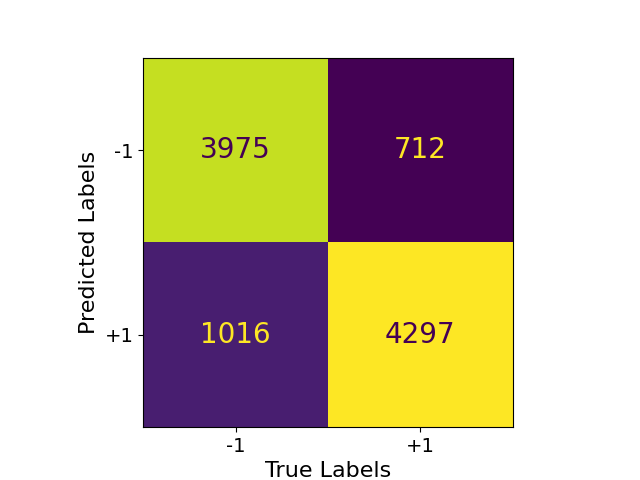

In [24]:
X_test_tensor = torch.FloatTensor(X_test)

# Evaluate the neural network on the test set
prediction_probs = model_predict(best_mlp, X_test_tensor)
# Decision boundary set to 0.5, hence rounding up sigmoid outputs
predictions = np.round(prediction_probs)
# Return back to original encoding
predictions = lb.inverse_transform(predictions)

# Get indices of correct and incorrect labels
incorrect_ind = np.argwhere(y_test != predictions)
prob_error_test = len(incorrect_ind) / N_test
print("MLP Pr(error) on the test data set: %.4f\n" % prob_error_test)

fig, ax = plt.subplots(figsize=(10, 10));

plot_binary_classification_results(ax, predictions, y_test)

grid_tensor = torch.FloatTensor(grid)
# Make predictions across region of interest from before when plotting the SVM decision surfaces
best_mlp.eval()
Z = best_mlp(grid_tensor).detach().numpy()
Z = lb.inverse_transform(np.round(Z)).reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.25)

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title("MLP Decisions (RED incorrect) on Test Set")
plt.legend()
plt.tight_layout()
plt.show()

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(predictions, y_test)
conf_display = ConfusionMatrixDisplay.from_predictions(predictions, y_test, display_labels=['-1', '+1'], colorbar=False)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")
plt.show()

Text(0.5, 1.0, 'Airplane Image')

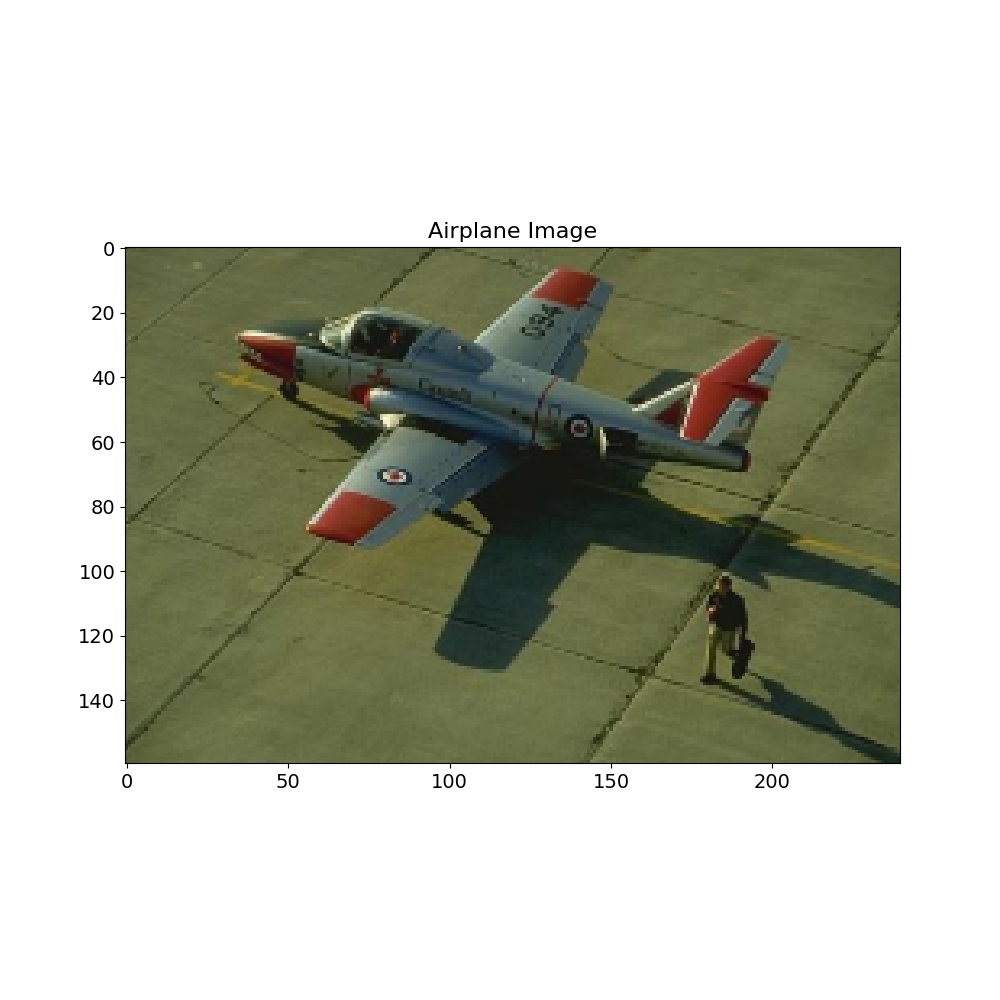

In [29]:
from skimage import transform
# Load the image
airplane_image = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/37073.jpg')
airplane_image = transform.resize(airplane_image, (airplane_image.shape[0] // 2, airplane_image.shape[1] // 2))
fig = plt.figure(figsize=(10,10))
plt.imshow(airplane_image)
plt.title("Airplane Image")


In [30]:
def generate_feature_vector(image):
    image_np = np.array(image)
    img_indices = np.indices((image_np.shape[0], image_np.shape[1]))

    if image_np.ndim == 2:
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(), image_np.flatten()])
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        normalized_data = np.diag(1/ranges).dot(features - min_f[:, np.newaxis])
    elif image_np.ndim == 3:
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(),
                             image_np[..., 0].flatten(), image_np[..., 1].flatten(), image_np[...,2].flatten()])
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        normalized_data = np.diag(1/ranges).dot(features - min_f[:, np.newaxis])
    else:
        print("Incorrect image dimensions for feature vector")
    
    return image_np, normalized_data.T

Text(0.5, 1.0, 'GMM Image Segmentation Result with $K = 4$')

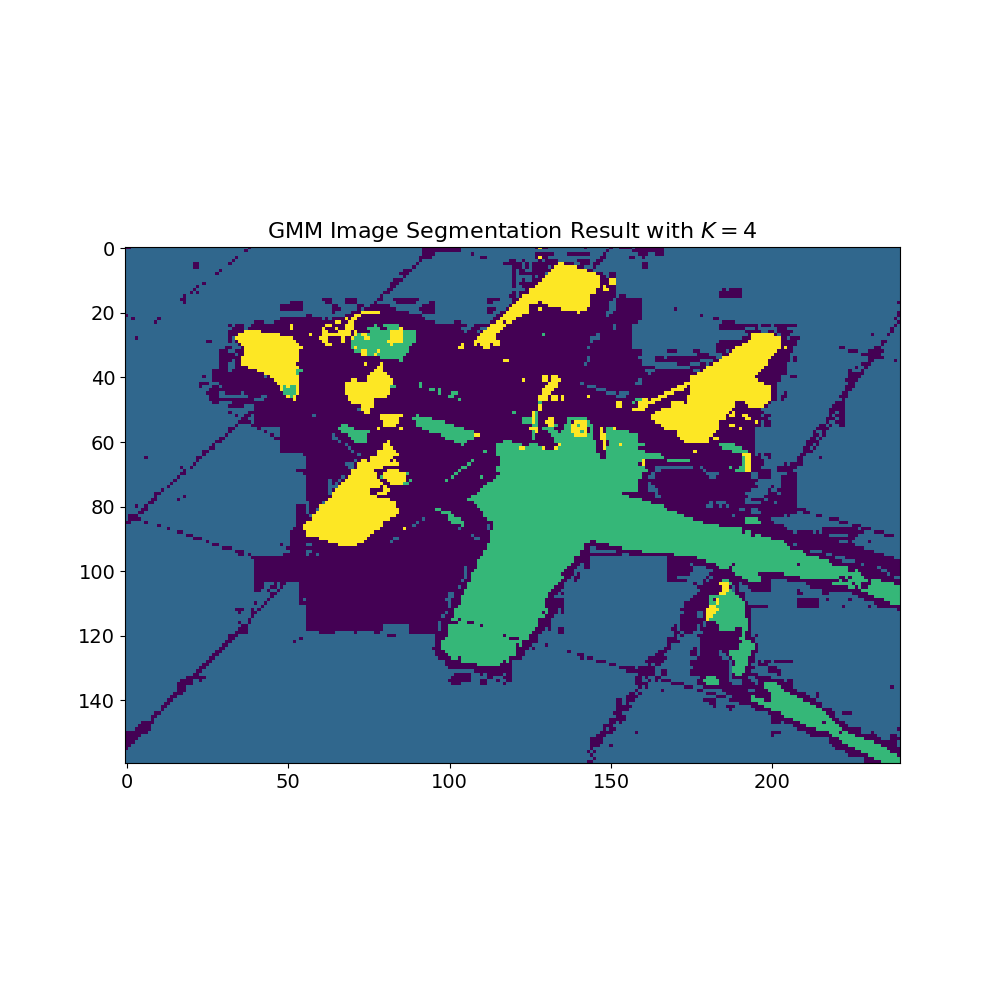

In [31]:
## Generate feature vector on the image
img_np, feature_vector = generate_feature_vector(airplane_image)   
    
# Perform EM to estimate the parameters of the GMM using fit() and default parameters
gmm = GaussianMixture(n_components=4, max_iter=400, tol=1e-3)

# Hard clustering using argmax to compute most probable component labels
gmm_predictions = gmm.fit_predict(feature_vector) 

# Assigned segment labels reshaped into an image to color-code pixels
labels_img = gmm_predictions.reshape(img_np.shape[0], img_np.shape[1])
fig = plt.figure(figsize=(10, 10))
plt.imshow(labels_img)
plt.title(r"GMM Image Segmentation Result with $K = 4$")

Best No. Cluster Components: 20
Log-likelihood ratio: 8.268


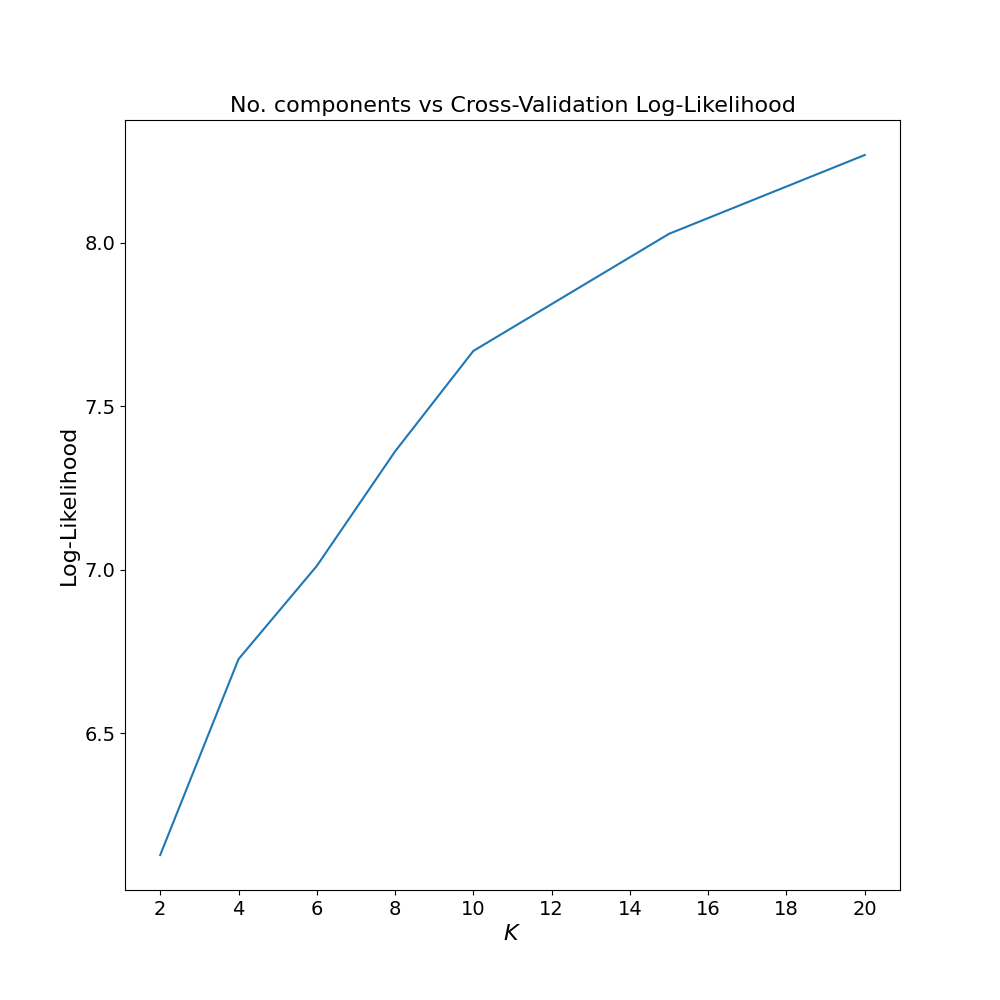

In [32]:
K_folds = 10
n_components_list = [2, 4, 6, 8, 10, 15, 20]

def k_fold_gmm_components(K, n_components_list, data):
    kf = KFold(n_splits=K, shuffle=True)
    log_lld_valid_mk = np.zeros((len(n_components_list), K))

    m = 0
    for comp in n_components_list:
        k = 0
        for train_indices, valid_indices in kf.split(data):
            gmm = GaussianMixture(n_components=comp, max_iter=400, tol=1e-3).fit(feature_vector)
            log_lld_valid_mk[m, k] = gmm.score(feature_vector)
            k += 1
        m += 1

    log_lld_valid_m = np.mean(log_lld_valid_mk, axis=1)
    best_three_ind = np.argpartition(log_lld_valid_m, -3)[-3:]
    best_three = best_three_ind[np.argsort((-log_lld_valid_m)[best_three_ind])]
    print("Best No. Cluster Components: %d" % n_components_list[best_three[0]])
    print("Log-likelihood ratio: %.3f" % np.max(log_lld_valid_m))

    fig = plt.figure(figsize=(10, 10))
    plt.plot(n_components_list, log_lld_valid_m)
    plt.title("No. components vs Cross-Validation Log-Likelihood")
    plt.xlabel(r"$K$")
    plt.ylabel("Log-Likelihood")
    ax = fig.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()
    return [n_components_list[i] for i in best_three]
best_three_components = k_fold_gmm_components(K_folds, n_components_list, feature_vector)


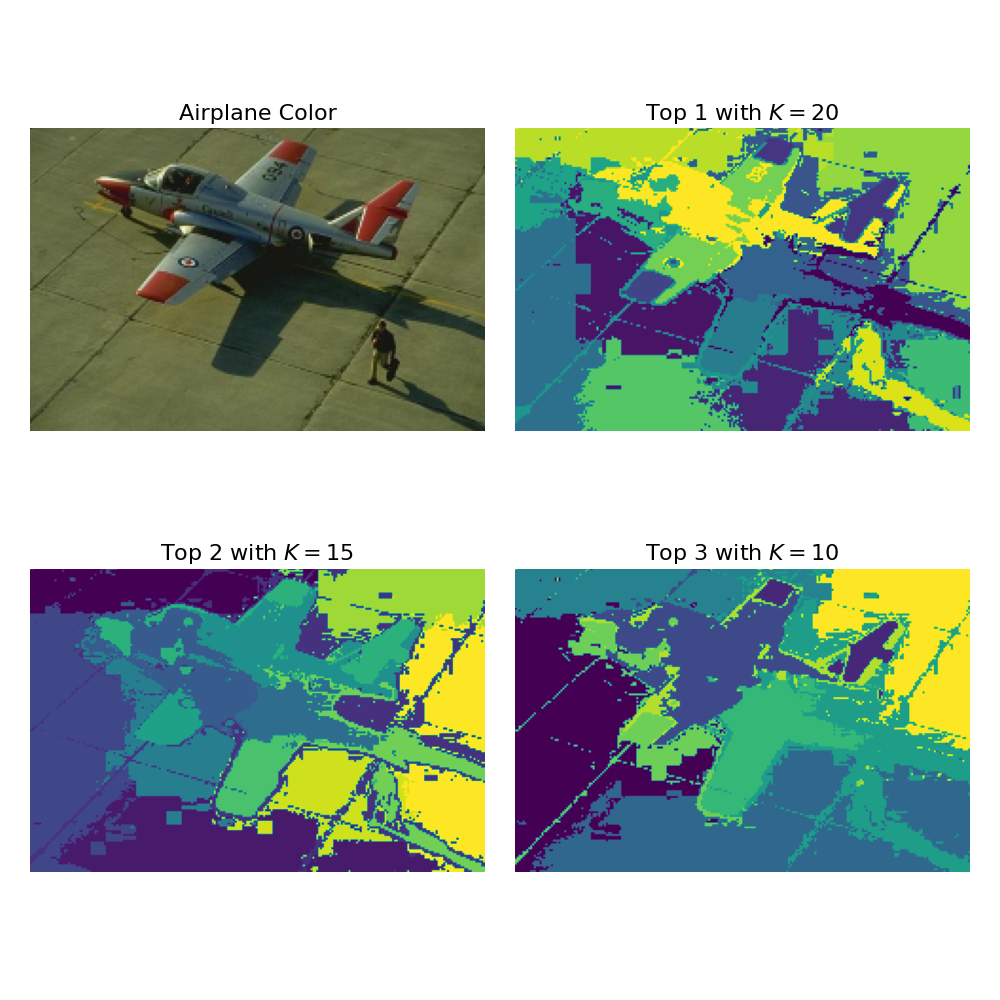

In [34]:
# Create figure to plot all GMM segmentation results for the example image
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(airplane_image)
ax[0,0].set_title("Airplane Color")
ax[0,0].set_axis_off()

# Plot axis index for each clustered image 
j = 1
for comp in best_three_components:
    gmm_predictions = GaussianMixture(n_components=comp, max_iter=400, tol=1e-3).fit_predict(feature_vector)
    labels_img = gmm_predictions.reshape(img_np.shape[0], img_np.shape[1])
    
    ax[floor(j/2),j%2].imshow(labels_img)
    ax[floor(j/2),j%2].set_title(fr"Top {j} with $K = {comp}$")
    ax[floor(j/2),j%2].set_axis_off()
    j += 1
    
plt.tight_layout()
plt.show()